In [1]:
import numpy as np
import pandas as pd
import pickle

import pulse2percept as p2p
import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-09 16:23:37,779 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
fname = '../../results/A_crossval-warm_12-005_2018-01-09_07-00-36.pickle'

In [3]:
y_true, y_pred, best_params, specifics = pickle.load(open(fname, 'rb'))

In [4]:
specifics

{'amplitude': 2.0,
 'electrodes': None,
 'fit_params': {'decay_const': 0,
  'loc_od_x': 15.5,
  'loc_od_y': 1.2,
  'scoring_weights': {'area': 0.001,
   'major_axis_length': 0.1,
   'minor_axis_length': 0.1,
   'orientation': 100.0},
  'use_ofl': False,
  'use_persp_trafo': False},
 'model_params': {'csmode': 'gaussian',
  'sampling': 200,
  'sensitivity_rule': 'decay',
  'thresh': 1.0},
 'n_folds': 5,
 'now': '2018-01-09_07-00-36',
 'optimizer': ParticleSwarmOptimizer(estimator=SpatialModelRegressor(csmode='gaussian', sampling=200,
            sensitivity_rule='decay', thresh=1.0, x_range=(-30, 30),
            y_range=(-20, 20)),
             greater_is_better=False, max_iter=100, min_func=0.01,
             search_params={'cswidth': (10, 1000), 'implant_y': (-1000, 1000), 'implant_x': (-1500, 1500), 'implant_rot': array([-1.309 , -0.2618])},
             swarm_size=40, verbose=True),
 'random_state': 42,
 'regressor': SpatialModelRegressor(csmode='gaussian', sampling=200,
          

In [5]:
p2pspatial.model_selection.crossval_score(y_true, y_pred, metric='r2')

[-1.9093658537742624,
 -1.7457596519335872,
 -1.7687137337662464,
 -1.8514652108809759,
 -1.6547088170803417]

## Plot all

In [6]:
data = {
    'A': {'12-005': '../../results/A_crossval-warm_12-005_2018-01-09_07-00-36.pickle',
          '51-009': '../../results/A_crossval-swarm_51-009_2018-01-09_07-06-53.pickle',
          '52-001': '../../results/A_crossval-swarm_52-001_2018-01-09_07-16-27.pickle'},
    'B': {'12-005': '../../results/A_crossval-warm_12-005_2018-01-09_07-00-36.pickle',
          '51-009': '../../results/A_crossval-swarm_51-009_2018-01-09_07-06-53.pickle',
          '52-001': '../../results/A_crossval-swarm_52-001_2018-01-09_07-16-27.pickle'},
    'C': {'12-005': '../../results/A_crossval-warm_12-005_2018-01-09_07-00-36.pickle',
          '51-009': '../../results/A_crossval-swarm_51-009_2018-01-09_07-06-53.pickle',
          '52-001': '../../results/A_crossval-swarm_52-001_2018-01-09_07-16-27.pickle'}
}

In [7]:
models = np.sort(list(data.keys()))
models

array(['A', 'B', 'C'], 
      dtype='<U1')

In [8]:
subjects = set()
for _, v in data.items():
    subjects = subjects.union(v)
subjects = np.sort(list(subjects))
subjects

array(['12-005', '51-009', '52-001'], 
      dtype='<U6')

In [9]:
metric = 'r2'
scores_mu = {}
scores_std = {}
for model, datafile in data.items():
    mu = []
    std = []
    for subject, fname in datafile.items():
        y_true, y_pred, best_params, specifics = pickle.load(open(fname, 'rb'))
        scores = p2pspatial.model_selection.crossval_score(y_true, y_pred, metric=metric)
        mu.append(np.mean(scores))
        std.append(np.std(scores))
    scores_mu[model] = mu
    scores_std[model] = std

In [10]:
scores_mu

{'A': [-1.786002653487083, -1.0942487096255635, -1.1576145948658887],
 'B': [-1.786002653487083, -1.0942487096255635, -1.1576145948658887],
 'C': [-1.786002653487083, -1.0942487096255635, -1.1576145948658887]}

In [11]:
plt.figure(figsize=(8, 10))
rects = []
set(scores_mu).intersection(scores_std)

{'A', 'B', 'C'}

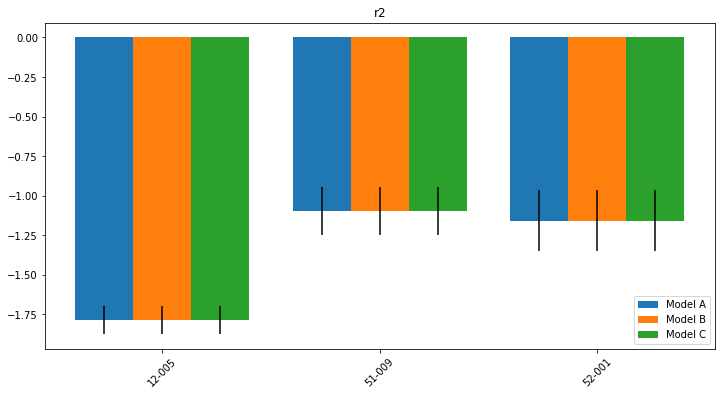

In [12]:
plt.figure(figsize=(12, 6))
N = len(subjects)
width = 0.8 / N
ind = np.arange(N)

rects = []
for m, model in enumerate(models):
    rects.append(plt.bar(ind + m * width, scores_mu[model], width, yerr=scores_std[model]))
plt.legend([r[0] for r in rects], ['Model ' + mm for mm in models])
plt.xticks(ind + (N - 1) / 2 * width, subjects, rotation=45, ha='center')
plt.title(metric)